In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import yfinance as yf
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [ ]:
# Initialize Firebase
cred = credentials.Certificate('/content/drive/MyDrive/Predictions/financiaflutter-firebase-adminsdk-ajaw7-f515e50a59.json')
firebase_admin.initialize_app(cred)

In [ ]:
crypto_currency = 'TRX'
against_currency = 'USD'

start = dt.datetime(2016,1,1)
end = dt.datetime.now()

data = yf.download('TRX-USD', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


Prepare Data

In [ ]:
print(data.head())

                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2017-11-09  0.002304  0.002438  0.002285  0.002344   0.002344  2924350
2017-11-10  0.002335  0.002350  0.001989  0.002013   0.002013  2193620
2017-11-11  0.002026  0.002298  0.001890  0.002003   0.002003  1748460
2017-11-12  0.002006  0.002006  0.001684  0.001783   0.001783  2174370
2017-11-13  0.001795  0.002146  0.001771  0.002112   0.002112  2889150


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scalar= MinMaxScaler(feature_range=(0,1))
scaled_data =scalar.fit_transform(data['Close'].values.reshape(-1,1))

In [ ]:
prediction_days = 60
future_day = 10

x_train, y_train=[], []

In [ ]:
for x in range(prediction_days, len(scaled_data)-future_day):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x+future_day, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Create Neural Network

In [ ]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
64/64 [==============================] - 14s 121ms/step - loss: 0.0082
Epoch 2/25
64/64 [==============================] - 6s 92ms/step - loss: 0.0041
Epoch 3/25
64/64 [==============================] - 8s 119ms/step - loss: 0.0038
Epoch 4/25
64/64 [==============================] - 6s 88ms/step - loss: 0.0034
Epoch 5/25
64/64 [==============================] - 8s 118ms/step - loss: 0.0034
Epoch 6/25
64/64 [==============================] - 7s 110ms/step - loss: 0.0032
Epoch 7/25
64/64 [==============================] - 7s 117ms/step - loss: 0.0035
Epoch 8/25
64/64 [==============================] - 6s 91ms/step - loss: 0.0032
Epoch 9/25
64/64 [==============================] - 7s 117ms/step - loss: 0.0030
Epoch 10/25
64/64 [==============================] - 6s 88ms/step - loss: 0.0031
Epoch 11/25
64/64 [==============================] - 7s 109ms/step - loss: 0.0031
Epoch 12/25
64/64 [==============================] - 7s 103ms/step - loss: 0.0030
Epoch 13/25
64/64 [=========

Testing the model

In [ ]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download('TRX-USD', start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

[*********************100%***********************]  1 of 1 completed


In [ ]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scalar.fit_transform(model_inputs)

In [ ]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
prediction_prices = model.predict(x_test)
prediction_prices = scalar.inverse_transform(prediction_prices)

41/41 [==============================] - 2s 28ms/step


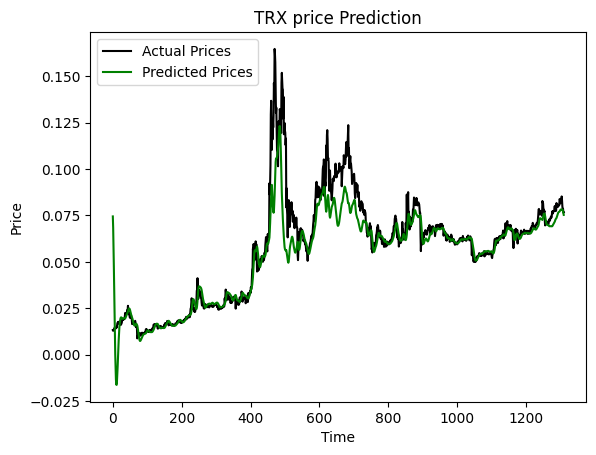

In [ ]:
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title('TRX price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc = 'upper left')
plt.show()

# Predict next day

In [ ]:
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)


In [ ]:
real_data.shape

(1, 59)

In [ ]:
real_data = np.reshape(real_data, (real_data.shape[0],real_data.shape[1], 1))

In [ ]:
prediction = model.predict(real_data)
prediction = scalar.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 1s 1s/step
[[0.07432398]]


In [ ]:
# Save the prediction value to Firebase Firestore
db = firestore.client()
doc_ref = db.collection('predictioncrypto').document(crypto_currency)
doc_ref.set({
    'prediction': float(prediction[0][0])
})

update_time {
  seconds: 1691397516
  nanos: 873293000
}